In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
explain_vars = [
    "doy",
    "LIA",
    "VH",
    "VV",
    "VVVH_ratio",
    "angle",
    "sm_1",
    "sm_3",
    "sm_7",
    "sm_30",
    "precipitation",
    "prec_3",
    "prec_7",
    "prec_30",
    "elevation",
    "aspect",
    "slope",
    "land_cov",
    "canopy_height",
    "gldas_mean",
    "gldas_stddev",
    "B3",
    "B4",
    "B5",
    "B7",
    "ndvi",
    "ndmi",
    "ndbri",
    "doy"
]
response_var = ["gwl_cm"]
len(explain_vars)

29

In [44]:
explanatory_file_path = "data/7_training_data/explanatory_with_response_var.csv"
df = pd.read_csv(explanatory_file_path)
print("lenght of df: ", len(df))
# Drop duplicates on id and date
df = df.drop_duplicates(subset=["id", "date"])
print("lenght of df after dropping duplicates: ", len(df))

# Find if there are any NaNs and remove them from the dataset 
# Some NAN values are still present in the dataset, probably due to the fact that some of the
# points fall outside bounds of GLDSA dataset
df = df[~df.isna().any(axis=1)]

print("lenght of df after droping any nan values: ", len(df))

lenght of df:  35382
lenght of df after dropping duplicates:  33366
lenght of df after droping any nan values:  32340


In [57]:
shp_path = Path("data/0_shp/")
region_path = "regions_to_request_explanatory_all.gpkg"
gdf_regions = gpd.GeoDataFrame.from_file(shp_path/region_path)

unique_coords = df[["id", 'lon', 'lat']].drop_duplicates()
len(df), len(unique_coords)

# Create geodataframe from x y coordinates
station_with_region_df = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.lon, unique_coords.lat), crs="EPSG:4326")

# # Add the region id to each point
station_with_region_df = gpd.sjoin(station_with_region_df, gdf_regions[["region_id", "geometry"]], how="left", predicate="within")

# Merge the region id to the main dataframe
df = df.merge(station_with_region_df[["id", "region_id"]], on="id", how="left")
df

,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,angle,...,gldas_stddev,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy,region_id
0,02_AHL_SBG-B076,2021-06-01,-41.000,3.937760,117.007750,32.785855,-11.481278,-5.556430,0.207099,36.787151,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,152,10
1,02_AHL_SBG-B076,2021-08-24,-38.000,3.937760,117.007750,32.785295,-12.812067,-5.960235,0.201164,36.786694,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,236,10
2,02_AHL_SBG-B076,2022-04-09,-22.000,3.937760,117.007750,32.795191,-18.437775,-10.636812,0.072032,36.796555,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,99,10
3,02_AHL_SBG-B076,2023-02-15,-31.000,3.937760,117.007750,32.793740,-13.051827,-9.007584,0.076149,36.807916,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,46,10
4,02_AHL_SBG-B101,2021-06-01,-66.000,3.931860,117.010120,39.267563,-9.778736,-6.648683,0.111111,36.787151,...,1.811218,21,75,57,25,0.562500,0.136364,0.500000,152,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32335,kalteng1,2020-03-31,-0.271,-2.319728,114.058131,32.480674,-13.179518,-7.523130,0.128794,34.187180,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,91,8
32336,kalteng1,2020-04-12,-0.114,-2.319728,114.058131,32.474638,-12.679995,-7.348031,0.130210,34.181156,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,103,8
32337,kecil1,2019-03-01,-2.954,-2.856089,113.805611,35.143679,-10.922965,-7.574065,0.093967,35.013103,...,3.362376,24,76,69,32,0.520000,0.048276,0.407407,60,8
32338,kecil1,2019-06-29,-2.922,-2.856089,113.805611,35.139013,-11.637249,-7.424729,0.112345,35.008472,...,3.362376,24,76,69,32,0.520000,0.048276,0.407407,180,8


In [58]:
# count the number of points per region
df.groupby("region_id").count()["id"]

region_id
1       248
2      3769
3        77
4      7595
5     14076
6       397
7      2961
8      2548
9       242
10      427
Name: id, dtype: int64

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


In [40]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,id,date_count
1968,BRG_150710_03,261
1967,BRG_150710_02,229
1957,BRG_140806_01,228
745,15_RAPP_PPDV-05a,212
779,15_RAPP_PPDVIII-23,206
...,...,...
1269,199_GAL_B36,1
262,10_MTI_MTI_H175_P3,1
272,10_MTI_MTI_H181_P3,1
280,10_MTI_MTI_H193_P3,1


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 250, 500],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['mse', 'friedman_mse']
}
variable = 'gwl_cm'
temporal_expl = [
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]
row = {}

for station_id in df['id'].unique():

    train_data = df[df['id'] != station_id]
    test_data = df[df['id'] == station_id]
    X_train, X_test = train_data[explain_vars], test_data[explain_vars]
    y_train, y_test = train_data[variable], test_data[variable]

    regr = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
    grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_regr = grid_search.best_estimator_
    
    y_pred = best_regr.predict(X_test)

    r, _ = pearsonr(test_data[variable].values, y_pred)
    correlations = [r]
    correlations.extend([test_data[variable].corr(test_data[expl]) for expl in temporal_expl])
    row[station_id] = correlations

stats_df = pd.DataFrame.from_dict(row, orient='index')


In [72]:
variable = "gwl_cm"
row = {}
temporal_expl = []
training_df = df[df.region_id == 2].copy()
temporal_expl = [
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]


for i, station_id in enumerate(training_df.id.unique()):
    
    
    # add first element gwl-smm correlation to station_id
    explans = []
    
    # create a df for training without the station_id
    gdf_train = training_df[training_df.id != station_id]
    
    # create a df for test of the station_id
    gdf_test = training_df[training_df.id == station_id]
        
    X_train, X_test = gdf_train[explain_vars], gdf_test[explain_vars]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='friedman_mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    #r2 = r2_score(y_test, y_pred_test)
    #explans.append(r2)
    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
        
    row[station_id] = explans
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

In [70]:
stats_df.columns = ["friedman_mse"] + temporal_expl

<Axes: >

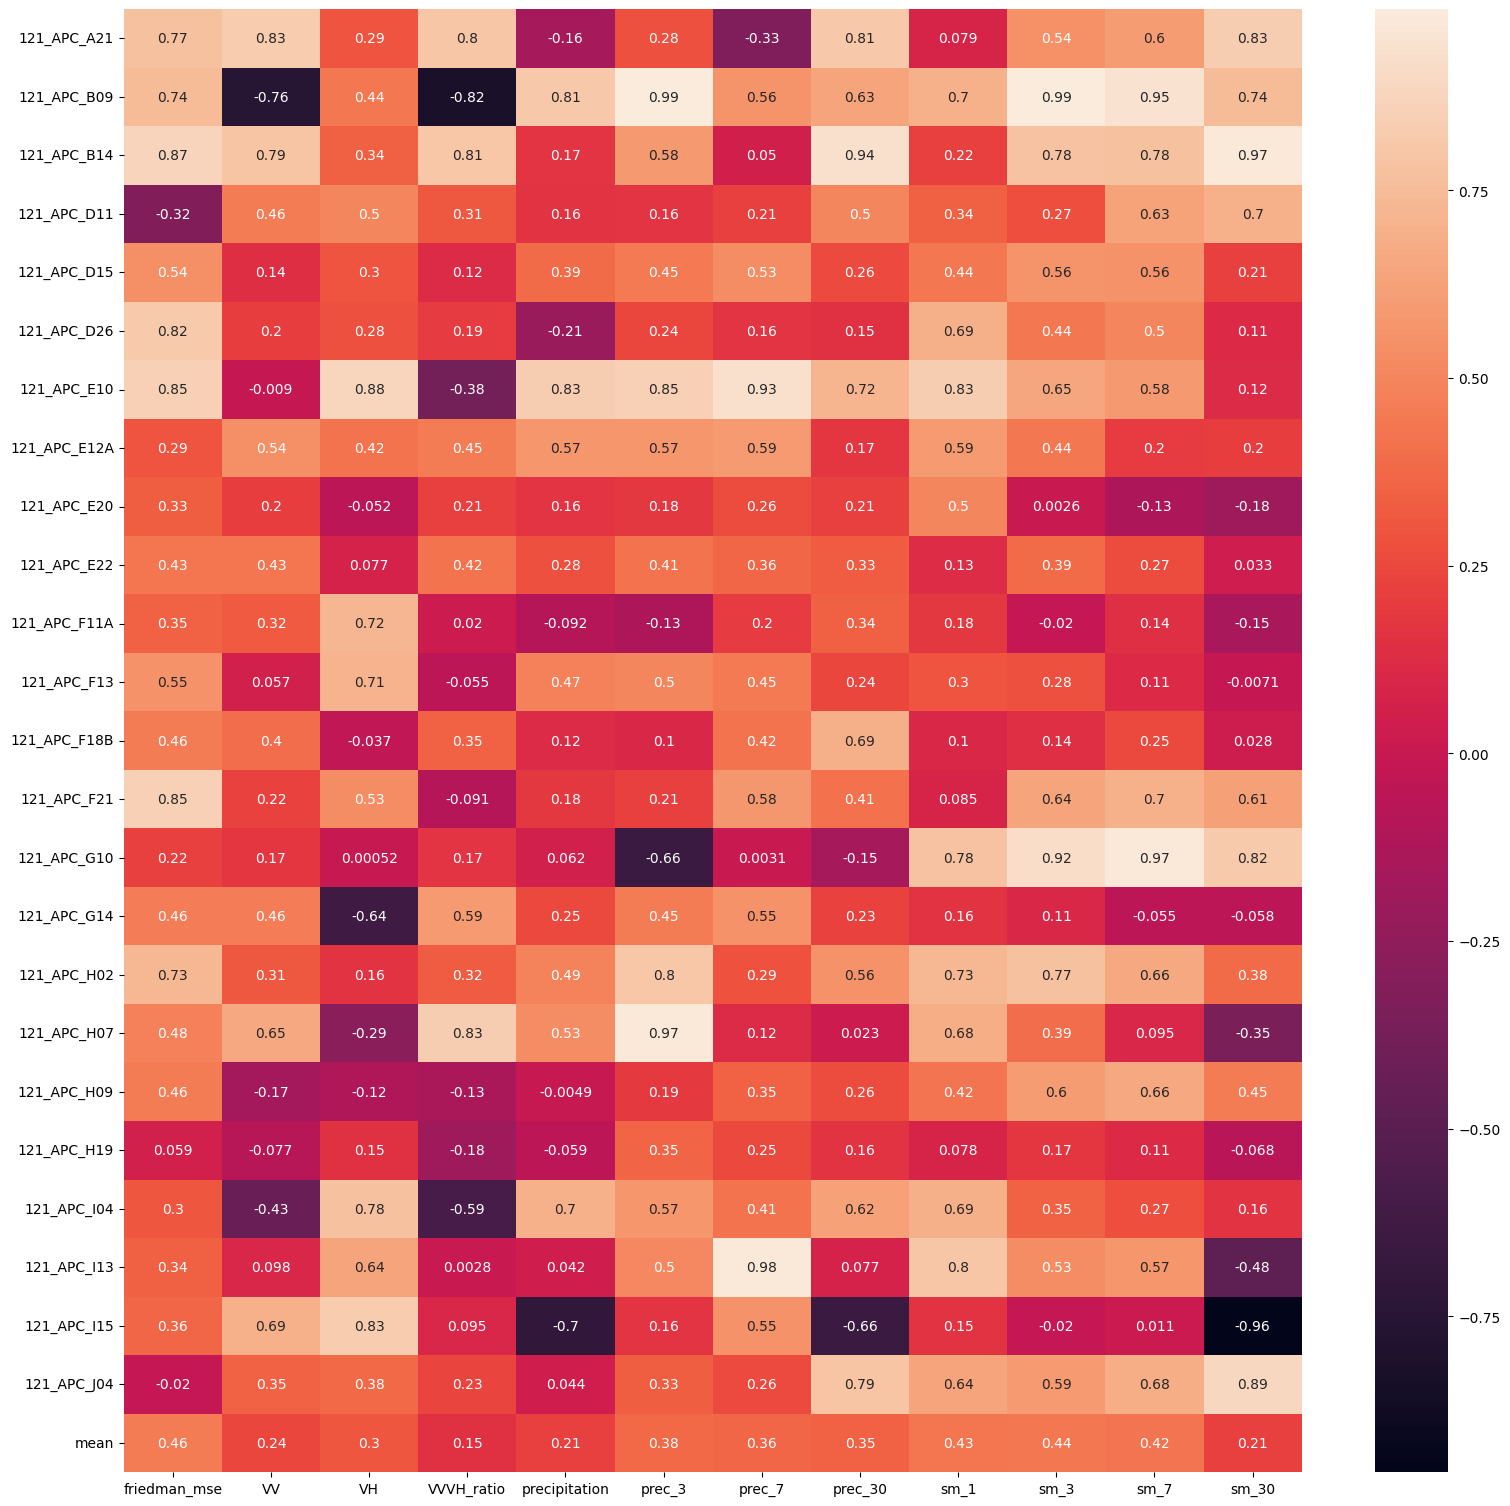

In [71]:
from matplotlib import pyplot as plt


stats_df.loc['mean'] = stats_df.mean()
sns.heatmap(stats_df, annot=True)

figures_path = Path("data/8_figures/correlations/")
figures_path.mkdir(parents=True, exist_ok=True)

plt.savefig(figures_path/'correlation_by_group_1.png')